# Packages

In [ ]:
!pip install click 
!pip install numpy 
!pip3 install torch torchvision torchaudio 
!pip install wandb 
!pip install matplotlib 
!pip install colorcet 
!pip install scikit-image  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import colorcet as cc
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 1 - Review on Diffusion Models

### Forward Diffusion in DDPM

The training of a DDPM involves two parallel branches. The first branch is the **forward diffusion**. The goal of forward diffusion is to generate the intermediate variables (x<sub>1</sub>, ..., x<sub>T-1</sub>) by using:



![Forward Formula](./images/diffusion_forward_formula.png)

![Forward Process](./images/forward_process.png)

The forward diffusion does not require any training. If you give us the clean image x0, we can run the forward diffusion and prepare the images x<sub>1</sub>, . . . , x<sub>T</sub>.

### Trainig DDPM

Training DDPM. Once the training samples x<sub>0</sub>, . . . , x<sub>T</sub> are prepared, we can train the DDPM.  The goal is to train one denoiser for all noise levels. It is a one denoiser for all noise levels. We are not interested in training many denoisers because it is computationally not feasible.

![Training](./images/training.png)

Following algorithm explains the training objective:

![Training algorithm](./images/training_algorithm.png)

### Inference

Once the denoiser x<sub>θ</sub> is trained, we can apply it
to do the inference. The inference is about sampling images from the distributions p<sub>θ</sub>(x<sub>t-1</sub>|x<sub>t</sub>) over the
sequence of states x<sub>T</sub> , x<sub>T-1</sub>, . . . , x<sub>1</sub>.

![Inference algorithm](./images/inference_algorithm.png)

![Inference](./images/inference.png)

### Relationship between denoising and score

Denoising diffusion models are equivalent to score-based generative models. In these models, the score function, which represents the gradient of the log probability density, can be efficiently computed for Gaussian distributions. This is because the score of a Gaussian density is directly related to its mean and variance. 

![Score Diagram](./images/score_matching_figure.png)

![Score Based Loss](./images/score_matching_loss.png)

 # 2 -Self-supervised Training Loss

Training-loss formulation: field observations (RTMs and wells) along with columnwise masks (A) are sampled initially. Conditioned on these masks, further subsampling masks (A<sup>~</sup> ) are generated. The neural denoising model h<sub>θ</sub>, informed by the
sub-sampling masks, noisy sub-sampled well information and RTMs, is trained to reconstruct the complete, noise-free velocity model.

![SAGE Loss](./images/SAGE_loss_formulation.png)

Lets observe one sample from the dataset. 

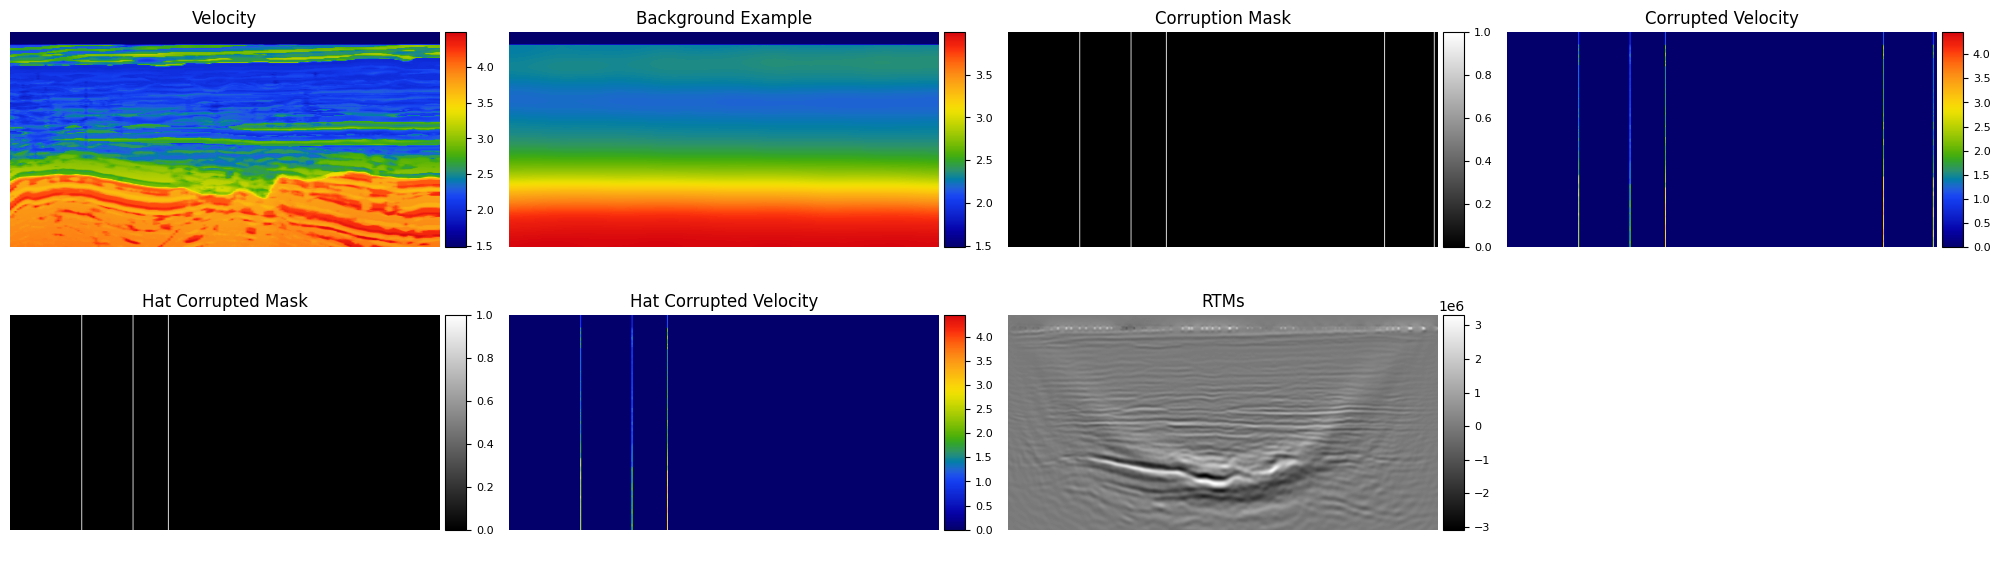

In [57]:
# Show ground truth velocity and examples of input
velocity = np.load('training_data/velocity/velocity_0000.npy')
background_example = np.load('training_data/background_velocity/back_0000.npy')
corruption_mask = np.load('training_data/corruption_mask/corruption_mask_0000.npy')
corrupted_velocity = np.load('training_data/corrupted_velocity/corrupted_velocity_0000.npy')
hat_corrupted_mask = np.load('training_data/hat_corruption_mask/hat_corruption_mask_0000.npy')
hat_corrupted_velocity = np.load('training_data/hat_corrupted_velocity/hat_corrupted_velocity_0000.npy')
rtm = np.load('training_data/rtms/rtm_0000.npy')

# List of images, titles, and colormaps
images = [velocity, background_example, corruption_mask, corrupted_velocity, hat_corrupted_mask, hat_corrupted_velocity, rtm]
titles = ['Velocity', 'Background Example', 'Corruption Mask', 'Corrupted Velocity', 'Hat Corrupted Mask', 'Hat Corrupted Velocity', 'RTMs']
colormaps = [cc.cm['rainbow4'], cc.cm['rainbow4'], 'gray', cc.cm['rainbow4'], 'gray', cc.cm['rainbow4'], 'gray']

fig, axes = plt.subplots(2, 4, figsize=(20, 6))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        im = ax.imshow(images[i], cmap=colormaps[i])
        ax.set_title(titles[i])
        ax.axis('off')  # Hide axes
        # Create a colorbar with the same height as the image
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=8)  # Adjust colorbar tick size

for j in range(len(images), len(axes.flat)):
    axes.flat[j].axis('off')

plt.tight_layout()
plt.show()

SAGE Loss only uses well information and seismic reflectivities 

In [58]:
# Define the SAGELoss
class SAGELoss:
    def __init__(self, P_mean=-1.2, P_std=1.2, sigma_data=0.5, norm=2):
        self.P_mean = P_mean
        self.P_std = P_std
        self.sigma_data = sigma_data

    def __call__(self, net, corrupted_image, cond, corruption_matrix, hat_corruption_matrix, augment_pipe=None):
        rnd_normal = torch.randn([corrupted_image.shape[0], 1, 1, 1])
        sigma = (rnd_normal * self.P_std + self.P_mean).exp()
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        n = torch.randn_like(corrupted_image) * sigma
        
        masked_image = hat_corruption_matrix * (corrupted_image + n)

        cat_input = torch.cat([masked_image, cond, hat_corruption_matrix], axis=1)
        D_yn = net(cat_input, sigma)
        
        loss = weight * ((corruption_matrix * (D_yn - corrupted_image)) ** 2)
    
        return loss.mean()

# Dummy network for demonstration
class DummyNet(torch.nn.Module):
    def forward(self, x, sigma):
        return x

# Create random examples
t_images = torch.tensor(corrupted_velocity).unsqueeze(0).unsqueeze(0) 
t_cond = torch.tensor(rtm).unsqueeze(0).unsqueeze(0) 
t_corruption_matrix = torch.tensor(corruption_mask).unsqueeze(0).unsqueeze(0) 
t_hat_corruption_matrix = torch.tensor(hat_corrupted_mask).unsqueeze(0).unsqueeze(0) 

loss_fn = SAGELoss()
net = DummyNet()
loss = loss_fn(net, t_images, t_cond, t_corruption_matrix, t_hat_corruption_matrix)

print(f"Train Loss: {loss.item()}")

Train Loss: 3120867072.0


# Evaluation of Results - Inference

We will sample a model that is pretrained on synthoseis seismic data using conditional diffusion loss and then fine-tuned on the BG Compass model using SAGE loss. A total of 16 samples will be produced

In [ ]:
import subprocess

command = [
    "python", "inference/SAGE_inference.py",
    "--network_loc", "/opt/SLIM-Storage/network_parameters",
    "--cond_loc", "./test_data/rtms/",
    "--back_loc", "./test_data/backs/",
    "--gt_loc", "./test_data/gts/",
    "--cond_norm", "400000",
    "--gt_norm", "4.5",
    "--num_generate", "2"
]

result = subprocess.run(command, capture_output=True, text=True)

# Print the output
print(result.stdout)
print(result.stderr)

['rtm_0851.npy', 'rtm_0850.npy']
net.sigma_min
0.75
net.sigma_max
80
net.sigma_min
0.75
net.sigma_max
80
SSIM:0.7681494484079348
rmses:0.12652772222578074
net.sigma_min
0.75
net.sigma_max
80
net.sigma_min
0.75
net.sigma_max
80
SSIM:0.7395692615285409
rmses:0.14106191820921862


100%|██████████| 2/2 [00:11<00:00,  6.00s/it]

100%|██████████| 2/2 [00:11<00:00,  5.64s/it]



We calculate posterior mean of 16 samples:

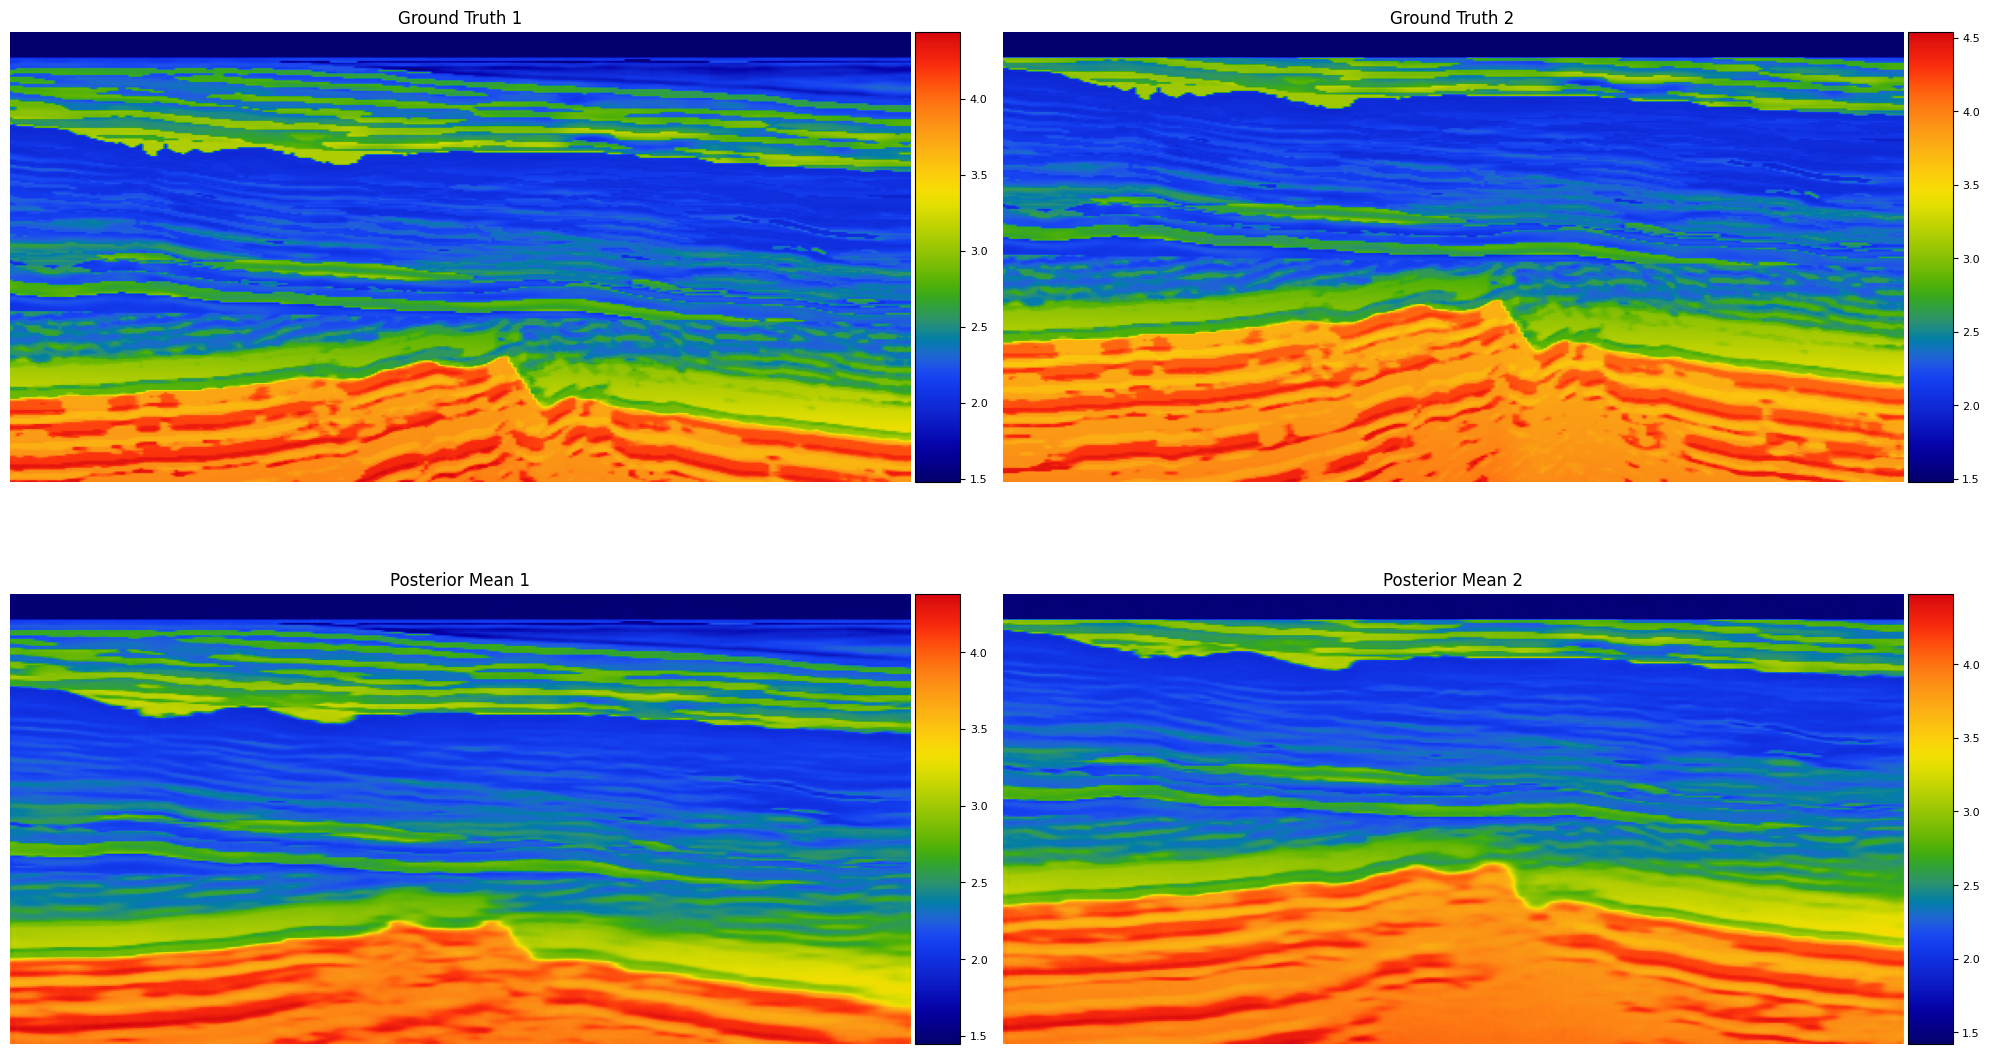

In [ ]:
# Plot posterior mean
gt1 = np.load('test_data/gts/gt_0850.npy')
gt2 = np.load('test_data/gts/gt_0851.npy')
post_mean1 = np.load('samples/1421/rtm_0850/saved/posterior_mean.npy')
post_mean2 = np.load('samples/1421/rtm_0851/saved/posterior_mean.npy')

images = [gt1, gt2, post_mean1, post_mean2]
titles = ['Ground Truth 1', 'Ground Truth 2', 'Posterior Mean 1', 'Posterior Mean 2']
colormaps = [cc.cm['rainbow4'], cc.cm['rainbow4'], cc.cm['rainbow4'], cc.cm['rainbow4']]

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        im = ax.imshow(images[i], cmap=colormaps[i])
        ax.set_title(titles[i])
        ax.axis('off')  # Hide axes
        # Create a colorbar with the same height as the image
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=8)  # Adjust colorbar tick size

for j in range(len(images), len(axes.flat)):
    axes.flat[j].axis('off')

plt.tight_layout()
plt.show()

We calculate posterior standard deviation of 16 samples:

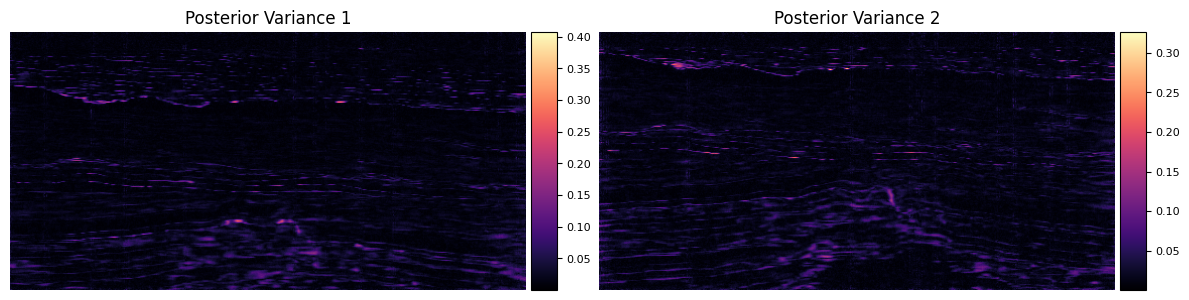

In [48]:
# Plot posterior std
post_std1 = np.load('samples/1421/rtm_0850/saved/posterior_std.npy')
post_std2 = np.load('samples/1421/rtm_0851/saved/posterior_std.npy')

images = [post_std1, post_std2]
titles = ['Posterior Variance 1', 'Posterior Variance 2']
colormaps = ["magma", "magma"]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        im = ax.imshow(images[i], cmap=colormaps[i])
        ax.set_title(titles[i])
        ax.axis('off')  # Hide axes
        # Create a colorbar with the same height as the image
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=8)  # Adjust colorbar tick size

for j in range(len(images), len(axes.flat)):
    axes.flat[j].axis('off')

plt.tight_layout()
plt.show()

# References

Review part: https://arxiv.org/pdf/2403.18103

SAGE model abstract: https://arxiv.org/pdf/2406.05136

Conditional diffusion: https://arxiv.org/abs/2411.06651

For architecture of network: https://arxiv.org/abs/2206.00364

# Github Repositories

General conditional diffusion: https://github.com/slimgroup/GeneralizedDiffusion